# New logistic regression model

## Assessing the predictive ability of a Scikit learn logisitc regression model 

Using a training and testing split of the DCD and DBD datasets to fit and assess the predictive ability of a logistic regression model fit with the same settings as the model used to varify the odds ratios

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as mets
%matplotlib inline

In [20]:
#import data
import pandas as pd

#Read in dataset with all rows included
df = pd.read_sas("Data/alldata3.sas7bdat")

#6931 DBD apps
dbd_apps = df[(df["eli_DBD"]==1)&(df["FAMILY_APPROACHED"]==2)]

#6060 DBD apps to match cohort in pape
dbd_apps = dbd_apps[(dbd_apps["eth_grp"]!=5)&(dbd_apps["FORMAL_APR_WHEN"]!=4)&(dbd_apps["donation_mentioned"]!=-1)
                    &(dbd_apps["FAMILY_WITNESS_BSDT"]!=9)&(dbd_apps["GENDER"]!=9)]
     
#9965 DCD apps
dcd_apps = df[(df["eli_DCD"]==1)&(df["FAMILY_APPROACHED"]==2)]

#9405 DCD apps to match cohort in paper
dcd_apps = dcd_apps[(dcd_apps["GENDER"]!=9)&(dcd_apps["cod_neuro"].notna())&(dcd_apps["eth_grp"]!=5)&(dcd_apps["donation_mentioned"]!=-1)&
                    (~dcd_apps["DTC_WD_TRTMENT_PRESENT"].isin([8,9]))]

# Columns used to create DBD model in paper
dbd_cols = ["wish", "FORMAL_APR_WHEN", "donation_mentioned", "app_nature", "eth_grp", "religion_grp", "GENDER", "FAMILY_WITNESS_BSDT", "DTC_PRESENT_BSD_CONV", 
            "acorn_new", "adult","FAMILY_CONSENT"]

dbd_apps[dbd_cols].astype(int)

dbd_model_data = dbd_apps[dbd_cols]
dbd_model_data2 = pd.get_dummies(data=dbd_model_data,columns=dbd_cols[:-1],drop_first=True)

dbd_features = dbd_model_data2.drop("FAMILY_CONSENT",axis=1)
dbd_consents = dbd_model_data2["FAMILY_CONSENT"]

# Columns used to create DCD model in paper
dcd_cols = ["wish", "donation_mentioned", 
            "app_nature", "eth_grp", "religion_grp", "GENDER", "DTC_WD_TRTMENT_PRESENT", 
            "acorn_new", "adult","cod_neuro","FAMILY_CONSENT"]

dcd_apps[dbd_cols].astype(int)

dcd_model_data = dcd_apps[dcd_cols]
dcd_model_data2 = pd.get_dummies(data=dcd_model_data,columns=dcd_cols[:-1],drop_first=True)

dcd_features = dcd_model_data2.drop("FAMILY_CONSENT",axis=1)
dcd_consents = dcd_model_data2["FAMILY_CONSENT"]

In [105]:
# creating a train and testing dataset for DBD and DCD approaches
DBD_X_train, DBD_X_test, DBD_y_train, DBD_y_test = train_test_split(dbd_features,dbd_consents, test_size=0.33, random_state=10)
DCD_X_train, DCD_X_test, DCD_y_train, DCD_y_test = train_test_split(dcd_features,dcd_consents, test_size=0.33, random_state=10)

DCD_y_test.value_counts()

2.0    1865
1.0    1239
Name: FAMILY_CONSENT, dtype: int64

In [42]:
# fitting DBD logistic regression to training data with same settings as verification model
LR_model = LogisticRegression(penalty='none',solver='newton-cg')

DBD_LR = LR_model.fit(DBD_X_train,DBD_y_train)

DBD_preds = DBD_LR.predict(DBD_X_test)
DBD_prob= DBD_LR.predict_proba(DBD_X_test)

mets.confusion_matrix(DBD_y_test, DBD_preds)

array([[ 271,  347],
       [ 132, 1250]])

In [120]:
# classification report for DBD model
print(mets.classification_report(DBD_y_test, DBD_preds))

print("Cohen kappa: " + str(round(mets.cohen_kappa_score(DBD_y_test, DBD_preds),2)))

              precision    recall  f1-score   support

         1.0       0.67      0.44      0.53       618
         2.0       0.78      0.90      0.84      1382

    accuracy                           0.76      2000
   macro avg       0.73      0.67      0.69      2000
weighted avg       0.75      0.76      0.74      2000

Cohen kappa: 0.38


In [106]:
# fitting DCD logistic regression to training data with same settings as verification model
LR_model = LogisticRegression(penalty='none',solver='newton-cg')

DCD_LR = LR_model.fit(DCD_X_train,DCD_y_train)

DCD_preds = DCD_LR.predict(DCD_X_test)
DCD_prob= DCD_LR.predict_proba(DCD_X_test)

mets.confusion_matrix(DCD_y_test, DCD_preds)

array([[ 772,  467],
       [ 395, 1470]])

In [119]:
# classification report for DCD model
print(mets.classification_report(DCD_y_test, DCD_preds))

print("Cohen kappa: " + str(round(mets.cohen_kappa_score(DCD_y_test, DCD_preds),2)))

              precision    recall  f1-score   support

         1.0       0.66      0.62      0.64      1239
         2.0       0.76      0.79      0.77      1865

    accuracy                           0.72      3104
   macro avg       0.71      0.71      0.71      3104
weighted avg       0.72      0.72      0.72      3104

Cohen kappa: 0.42


Text(0.5, 1.0, 'DBD and DCD ROC curves')

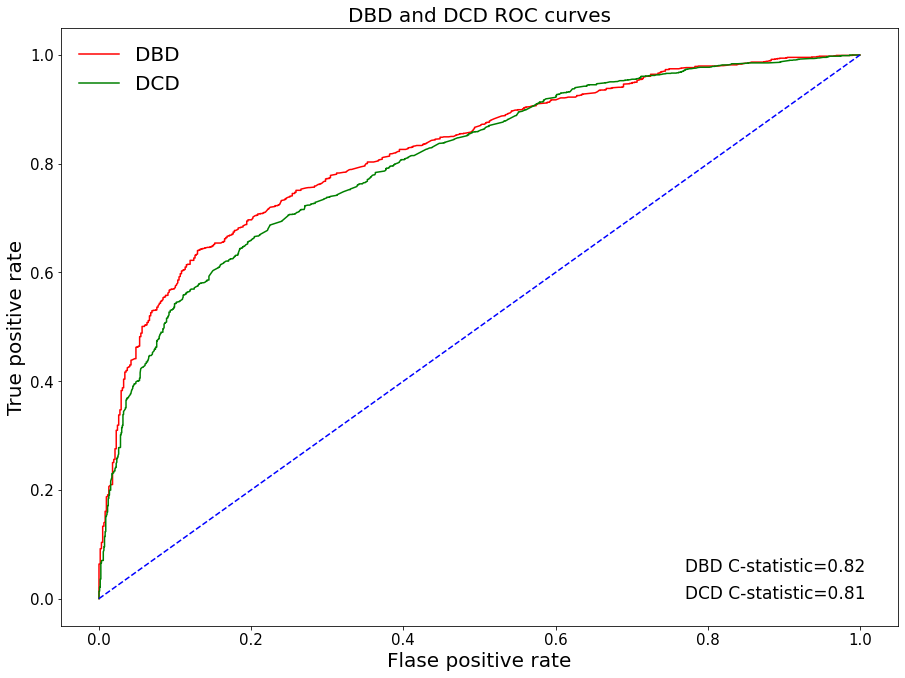

In [117]:
# ROC curve for both models
dbd_roc = mets.roc_curve(DBD_y_test, DBD_prob[:,1], pos_label=2)
dbd_auc = mets.roc_auc_score(DBD_y_test, DBD_prob[:,1], labels=[1,2])
dbd_c_stat = "DBD C-statistic=" + str(round(dbd_auc,2))

dcd_roc = mets.roc_curve(DCD_y_test, DCD_prob[:,1], pos_label=2)
dcd_auc = mets.roc_auc_score(DCD_y_test, DCD_prob[:,1], labels=[1,2])
dcd_c_stat = "DCD C-statistic=" + str(round(dcd_auc,2))


fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

ax.plot(dbd_roc[0],dbd_roc[1],"r")
ax.plot(dcd_roc[0],dcd_roc[1],"g")
ax.plot([0,1],[0,1],"--b")
ax.tick_params(axis="y",labelsize=15)
ax.tick_params(axis="x",labelsize=15)
ax.legend(["DBD","DCD"],loc="best",fontsize=20,frameon=False)

ax.text(0.77,0.05,dbd_c_stat, fontdict={'size':17, 'color':'black'})
ax.text(0.77,0,dcd_c_stat, fontdict={'size':17, 'color':'black'})

plt.xlabel("Flase positive rate",size=20)
plt.ylabel("True positive rate",size=20)
plt.title("DBD and DCD ROC curves",size=20)
